In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import time
import nltk

In [37]:
start = time.time()
def print_time(start):
  time_now = time.time()
  minutes = int(time_now/60)
  seconds = int(time_now % 60 )
  if seconds < 10:
    print('Elapsed time was %d:0%d.' % (minutes, seconds))
  else:
      print('Elapsed time was %d:%d.' % (minutes, seconds))

Load Data

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
df = pd.read_csv("/content/drive/MyDrive/Coding Projects/train.csv")

df_sub = pd.read_csv("/content/drive/MyDrive/Coding Projects/test.csv")

submission = pd.DataFrame()

submission["id"] = df_sub.id.copy()

In [40]:
def null_percentage(column):
  df_name = column.name
  nans = np.count_nonzero(column.isnull().values)
  total = column.size
  frac = nans / total
  perc = int(frac * 100)
  print('%d%% or %d missing from %s column.' %
  (perc, nans, df_name))

def check_null(df, columns):
  for col in columns:
    null_percentage(df[col])

check_null(df, df.columns)

0% or 0 missing from id column.
0% or 0 missing from comment_text column.
0% or 0 missing from toxic column.
0% or 0 missing from severe_toxic column.
0% or 0 missing from obscene column.
0% or 0 missing from threat column.
0% or 0 missing from insult column.
0% or 0 missing from identity_hate column.


EDA

In [41]:
print('%d features and %d records.' % (df.shape[1], df.shape[0]))
print()
targets = list(df.columns[2:])
print('Target columns: ' + ', '.join(targets))

8 features and 159571 records.

Target columns: toxic, severe_toxic, obscene, threat, insult, identity_hate


In [42]:
df.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


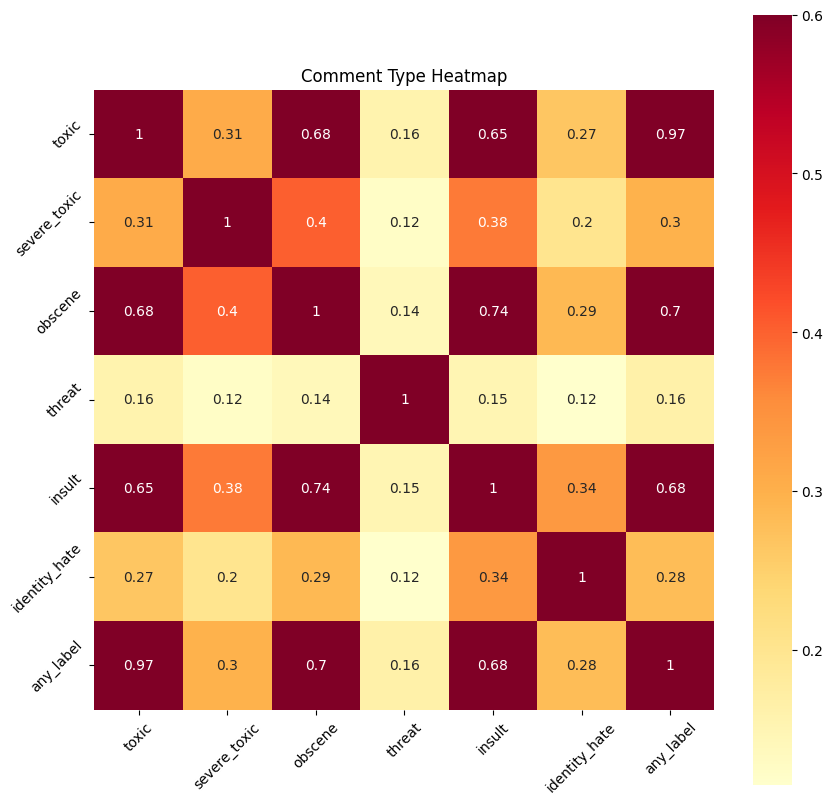

Training Data Comment Breakdown

16225 out of 159571 comments, or 10.17%, are classified as toxic.

15294 toxic comments. (9.58% of all data.)
- 1595 or 10.43% were also severe_toxic.
- 7926 or 51.82% were also obscene.
- 449 or 2.94% were also threat.
- 7344 or 48.02% were also insult.
- 1302 or 8.51% were also identity_hate.
- 15294 or 100.00% were also any_label.

1595 severe_toxic comments. (1.00% of all data.)
- 1595 or 100.00% were also toxic.
- 1517 or 95.11% were also obscene.
- 112 or 7.02% were also threat.
- 1371 or 85.96% were also insult.
- 313 or 19.62% were also identity_hate.
- 1595 or 100.00% were also any_label.

8449 obscene comments. (5.29% of all data.)
- 7926 or 93.81% were also toxic.
- 1517 or 17.95% were also severe_toxic.
- 301 or 3.56% were also threat.
- 6155 or 72.85% were also insult.
- 1032 or 12.21% were also identity_hate.
- 8449 or 100.00% were also any_label.

478 threat comments. (0.30% of all data.)
- 449 or 93.93% were also toxic.
- 112 or 23.43% w

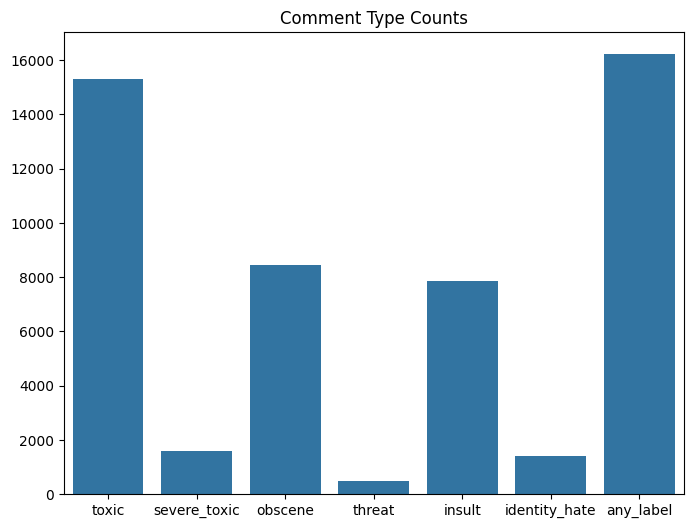

In [43]:
targets = list(df.columns[2:])
df_targets = df[targets].copy()

#How many rows are toxic?
toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)

#Create overall any label feature
targets.append('any_label')
df_targets['any_label'] = toxic_rows

count_dic = {}
for comment_type in targets:
  counts = list()
  others = list(targets)
  df_selection = df_targets [(df_targets [comment_type]==1)]
  others.remove(comment_type)
  counts.append(('total', len(df_selection)))
  for other in others:
    counts.append((other, df_selection [other].sum()))
  count_dic[comment_type] = counts

del(df_selection)

def heatmap(df, title):
  plt.figure('heatmap', figsize=[10,10])
  plt.title(title)
  df_corr = df.corr()
  #df_corr = np.triu(df_corr, k=1)
  sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
  plt.yticks(rotation = 45)
  plt.xticks(rotation = 45)
  plt.show()

heatmap(df_targets, 'Comment Type Heatmap')

print('Training Data Comment Breakdown')
print("================================\n")

print('%d out of %d comments, or %.2f%%, are classified as toxic.' %
 (np.sum(toxic_rows), len(df), (np.sum(toxic_rows)/len(df))*100))

totals = []

for key, value in count_dic.items():
  totals.append(value[0][1])
  print('\n%d %s comments. (%.2f%% of all data.)' % (value[0] [1], key, (value[0][1]/len (df))*100))
  for cnt in value[1:]:
    print('- %d or %.2f%% were also %s.' % (cnt[1], (cnt[1]/value[0][1])*100, cnt[0]))

plt.figure('Comment Type Counts', figsize=[8,6])
plt.title('Comment Type Counts')
sns.barplot(x=list(count_dic.keys()), y=totals)
plt.show()

In [44]:
for t in targets:
  print("Label: %s ====================================" %t)
  b = np.where(df_targets[t]==1)[0]
  selection = np.random.choice(b, 10)
  for s in selection:
    print(df.comment_text.loc[s])
    print("++++++++++++")
  print()

b= np.where(df_targets.any_label==0) [0]
selection = np.random.choice(b, 10)
print("Clean comments ===================================")

for s in selection:
  print(df.comment_text.loc[s])
  print("++++++++++++")

Label: toxic ====================================
"

 BLACK DAHLIA MURDER IS NOT 'MELODIC DEATH METAL'!!!!!!!!!!!!!!!!!!!!!!!!!!!!! THEY ARE DEATHCORE PUSSIES!!!!!!!!!!!!!!!!! 

Black Dahlia Murder IS NOT Melodic Death Metal. They are the farthest band from that genre. Black Dahlia Murder are pieces of shit scene bitches that are trying to be ""METAL"" along with all of the other Deathcore/Grindcore bands like Job For A Cowboy, Suicide Silence, etc. Fuck all of them! They aren't true Metal and they never will be, they need to stick to what they know...American Eagle, MTV, and all of their other lame trends. Melodic Death Metal is Scar Symmetry, In Flames, Sonic Syndicate, and Disarmonia Mundi. Melodic Death Metal is REAL music, it's not a disgrace to music like Deathcore and Grindcore.

I will continue to change Black Dahlia CUNT'Murder's genre to Deathcore/Grindcore, I don't give a shit..I'm not letting you stupid scene bitches take away the only thing that you and the Mainstream hasn

In [45]:
df['length'] = df.comment_text.apply(lambda x: len(x))
print("Average toxic comment length: %d" % int(np.mean(df[(df_targets.any_label==1)].length)))
print("Average clean comment length: %d" % int(np.mean(df[(df_targets.any_label==0)].length)))

Average toxic comment length: 303
Average clean comment length: 404


In [46]:
print("Median toxic comment length: %d" % int(np.median(df[(df_targets.any_label==1)].length)))

print("Median clean comment length: %d" % int(np.median(df[(df_targets.any_label==0)].length)))

Median toxic comment length: 128
Median clean comment length: 216


In [47]:
def pct_caps(s):
  return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))
print("Percent of capitalized characters in toxic comments: %d%%" % int(100*np.mean (df[(df_targets.any_label==1)].caps)))
print("Percent of capitalized characters in clean comments: %d%%" % int(100*np.mean(df[(df_targets.any_label==0)].caps)))

Percent of capitalized characters in toxic comments: 14%
Percent of capitalized characters in clean comments: 5%


In [48]:
def word_length(s):
  s= s.split(' ')
  return np.mean([len(w) for w in s if w.isalpha()])
df['word_length'] = df.comment_text.apply(lambda x: word_length(x))

print("Average word length in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].word_length))
print("Average word length in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].word_length))

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Average word length in toxic comments: 4.1
Average word length in clean comments: 4.4


In [49]:
df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))
print("Exclamations in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].exclamation))
print("Exclamations in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].exclamation))

Exclamations in toxic comments: 3.5
Exclamations in clean comments: 0.3


In [50]:
df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))
print("Question marks in toxic comments: %.1f" % np.mean(df[(df_targets.any_label==1)].question))
print("Question marks in clean comments: %.1f" % np.mean(df[(df_targets.any_label==0)].question))

Question marks in toxic comments: 0.6
Question marks in clean comments: 0.4


In [51]:
import re

ip= re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}' +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')

def strip_ip(s, ip):
  try:
               found = ip.search(s)
               return s.replace(found.group(),' ')
  except:
               return s

df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))

Label overlap summary.
1 label: 39.2%
2 labels: 21.4%
3 labels: 25.9%
4 labels: 10.8%
5 labels: 2.4%
6 labels: 0.2%


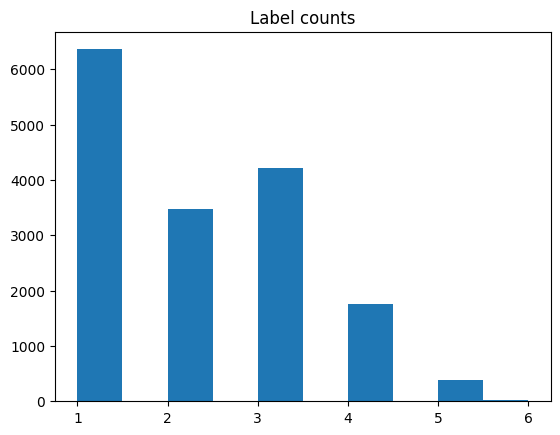

In [52]:
target_sums = np.sum(df_targets[df_targets.columns[:-1]], axis=1)
target_sums = target_sums[(df_targets.any_label==1)]
plt.figure('Label counts')
plt.title('Label counts')
plt.hist(target_sums)
print("Label overlap summary.")
for i in range(1,7):
  print('%d label%s: %.1f%%' % (i, 's' if i > 1 else'', 100 * len([s for s in target_sums if s == i])/len(target_sums)))

Splitting Labels from Training Data

In [53]:
print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data')
df.drop(list(df_targets.columns[:-1]), inplace=True, axis=1)
df.drop('id', inplace=True, axis=1)
print(list(df.columns))
print(df.shape)

Training labels:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'any_label']
(159571, 7)

Training data
['comment_text', 'length', 'caps', 'word_length', 'exclamation', 'question']
(159571, 6)


Natural Language Processing (NLP)

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from nltk.corpus import stopwords
import string

top_words = 5000
tokenizer = Tokenizer (filters=string.punctuation+'\n', lower=True, num_words=top_words)
tokenizer.fit_on_texts(df['comment_text'])


In [55]:
df['comment_sequence'] = tokenizer.texts_to_sequences(df.comment_text.str.lower())


In [56]:
# Random comment
str(df.comment_sequence[890])

'[1, 19, 641, 23, 1, 22, 856, 43, 19, 48, 2035, 2, 10, 13, 121, 126, 8, 201, 10, 412, 975, 1127, 17, 10, 10, 13, 8, 1, 1630, 856, 55, 95, 602, 39, 6, 125, 62, 2035, 981, 2379, 14, 969, 4, 3610, 17, 316, 17, 3, 72, 1, 531, 45, 1039, 2221, 641, 23, 62, 1907, 5, 4220, 319, 43, 8, 14, 97, 1, 1353, 4, 32, 842, 36, 42, 1813, 1493, 27, 13, 190, 18, 15, 1, 856, 24, 6, 95, 521, 43, 19, 2379, 39, 1, 2408, 4, 33, 1011, 2523, 2, 11, 2177, 319, 319]'

In [57]:
max_len = df.comment_sequence.map(lambda x: len(x)).max()
print("Max comment length is %d." % max_len)

Max comment length is 1399.


In [58]:
seq_lens = df.comment_sequence.map(lambda x: len(x))

In [59]:
for i in [10, 50, 100, 200, 300, 400, 500, 1000, 1200]:
   select = (seq_lens > i)
   print('%.2f%% of comments have more than %d words.' % ((np.sum(select)/len(seq_lens))*100, i))

83.34% of comments have more than 10 words.
35.22% of comments have more than 50 words.
16.06% of comments have more than 100 words.
5.61% of comments have more than 200 words.
2.62% of comments have more than 300 words.
1.63% of comments have more than 400 words.
1.08% of comments have more than 500 words.
0.02% of comments have more than 1000 words.
0.01% of comments have more than 1200 words.


In [64]:
def get_word_cnt(tokenizer):
  word_cnt = [(k, v) for k, v in zip(tokenizer.word_counts.keys(),
                                   tokenizer.word_counts.values())]
  word_cnt.sort(key = lambda tup: tup[1], reverse=True)
  stopWords = set(stopwords.words('english'))
  word_cnt = [tup for tup in word_cnt if tup[0] not in stopWords]
  return word_cnt

def word_plot(word_cnt, num_words, title):
  plt.figure(title, figsize=(24, 12))
  plt.suptitle(title, fontsize=40)
  sns.barplot(x= [tup[0] for tup in word_cnt[0:num_words]],
              y =[tup[1] for tup in word_cnt[0:num_words]])
  plt.yticks(fontsize=20)
  plt.xticks(fontsize=20, rotation=35, ha='right')
  plt.show()

In [65]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

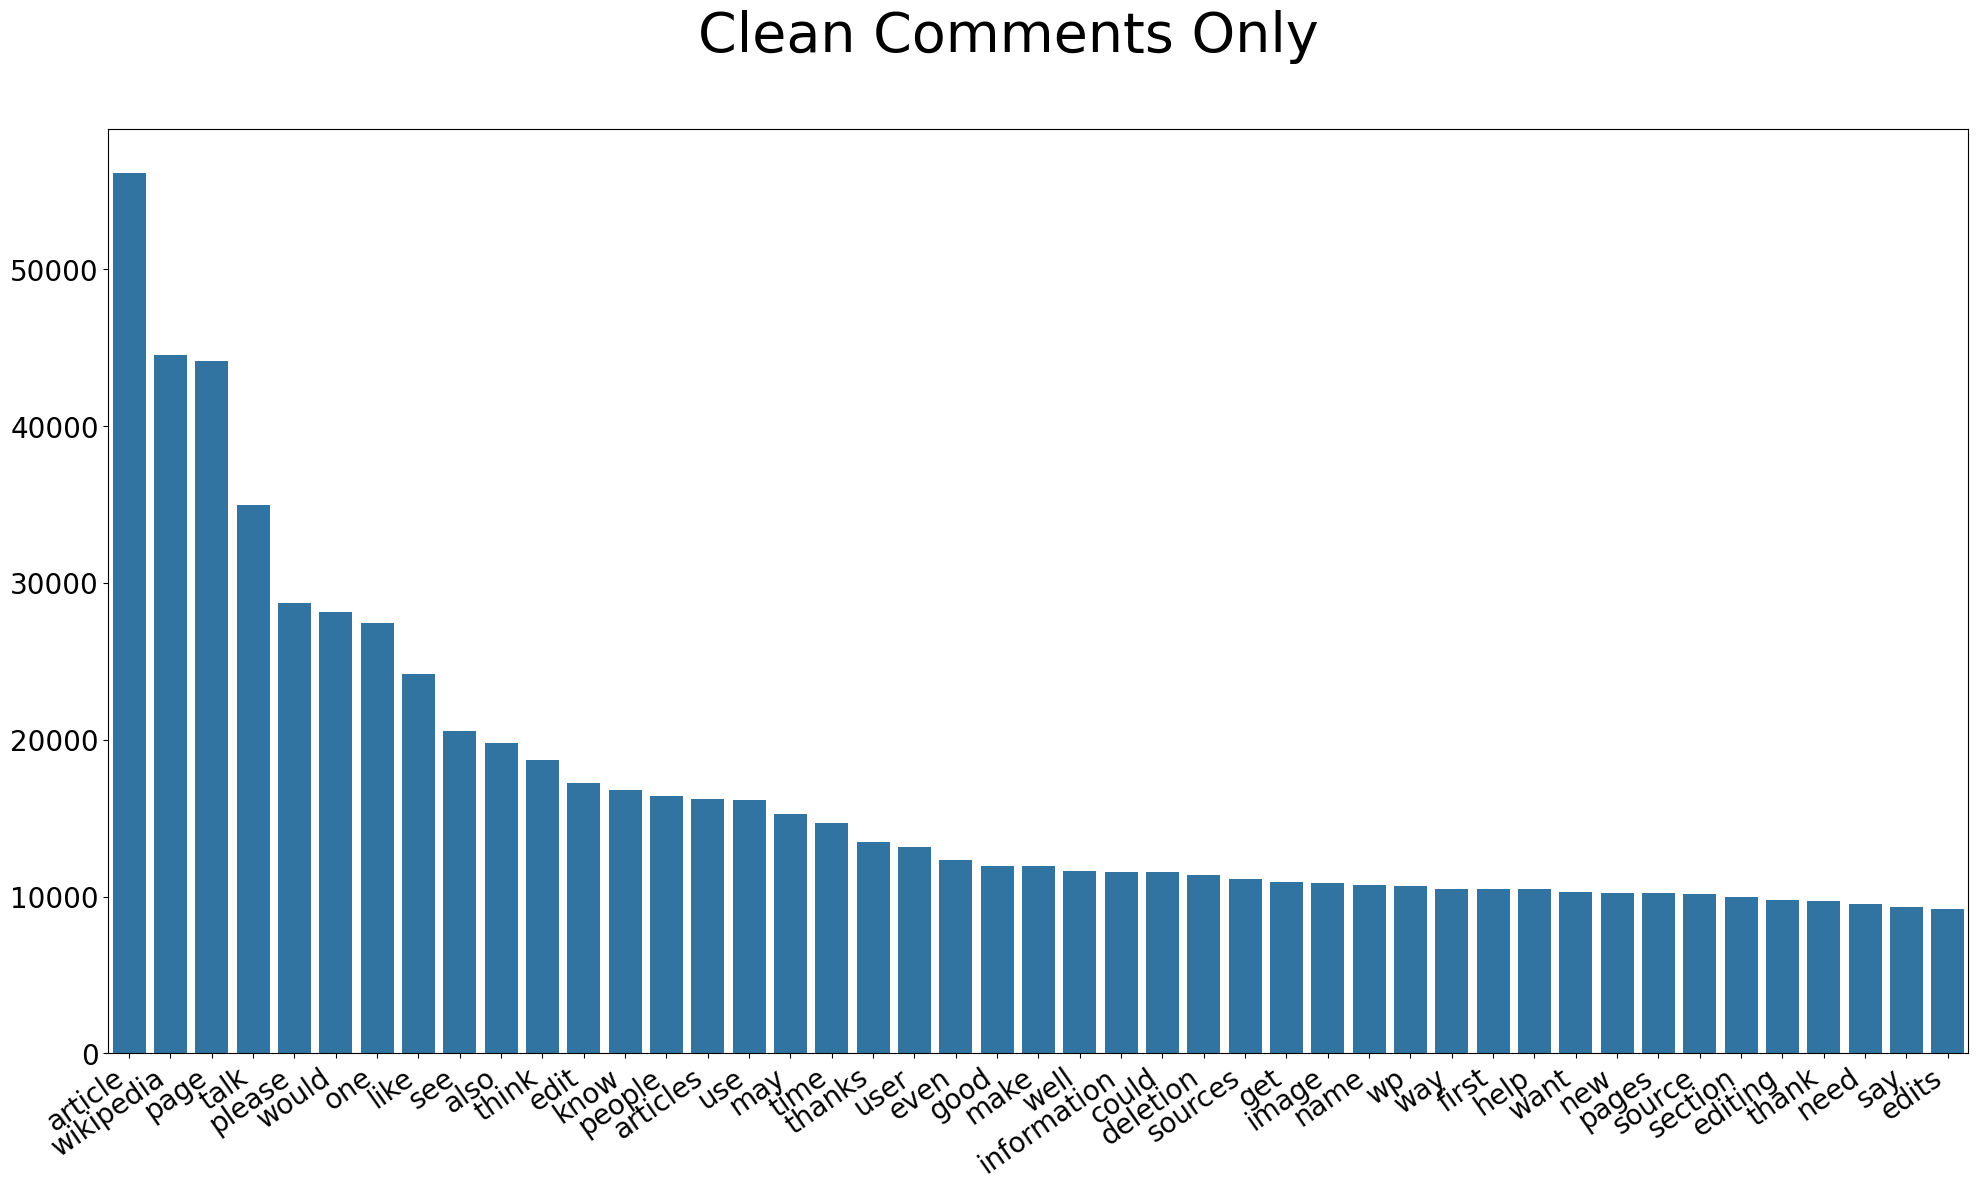

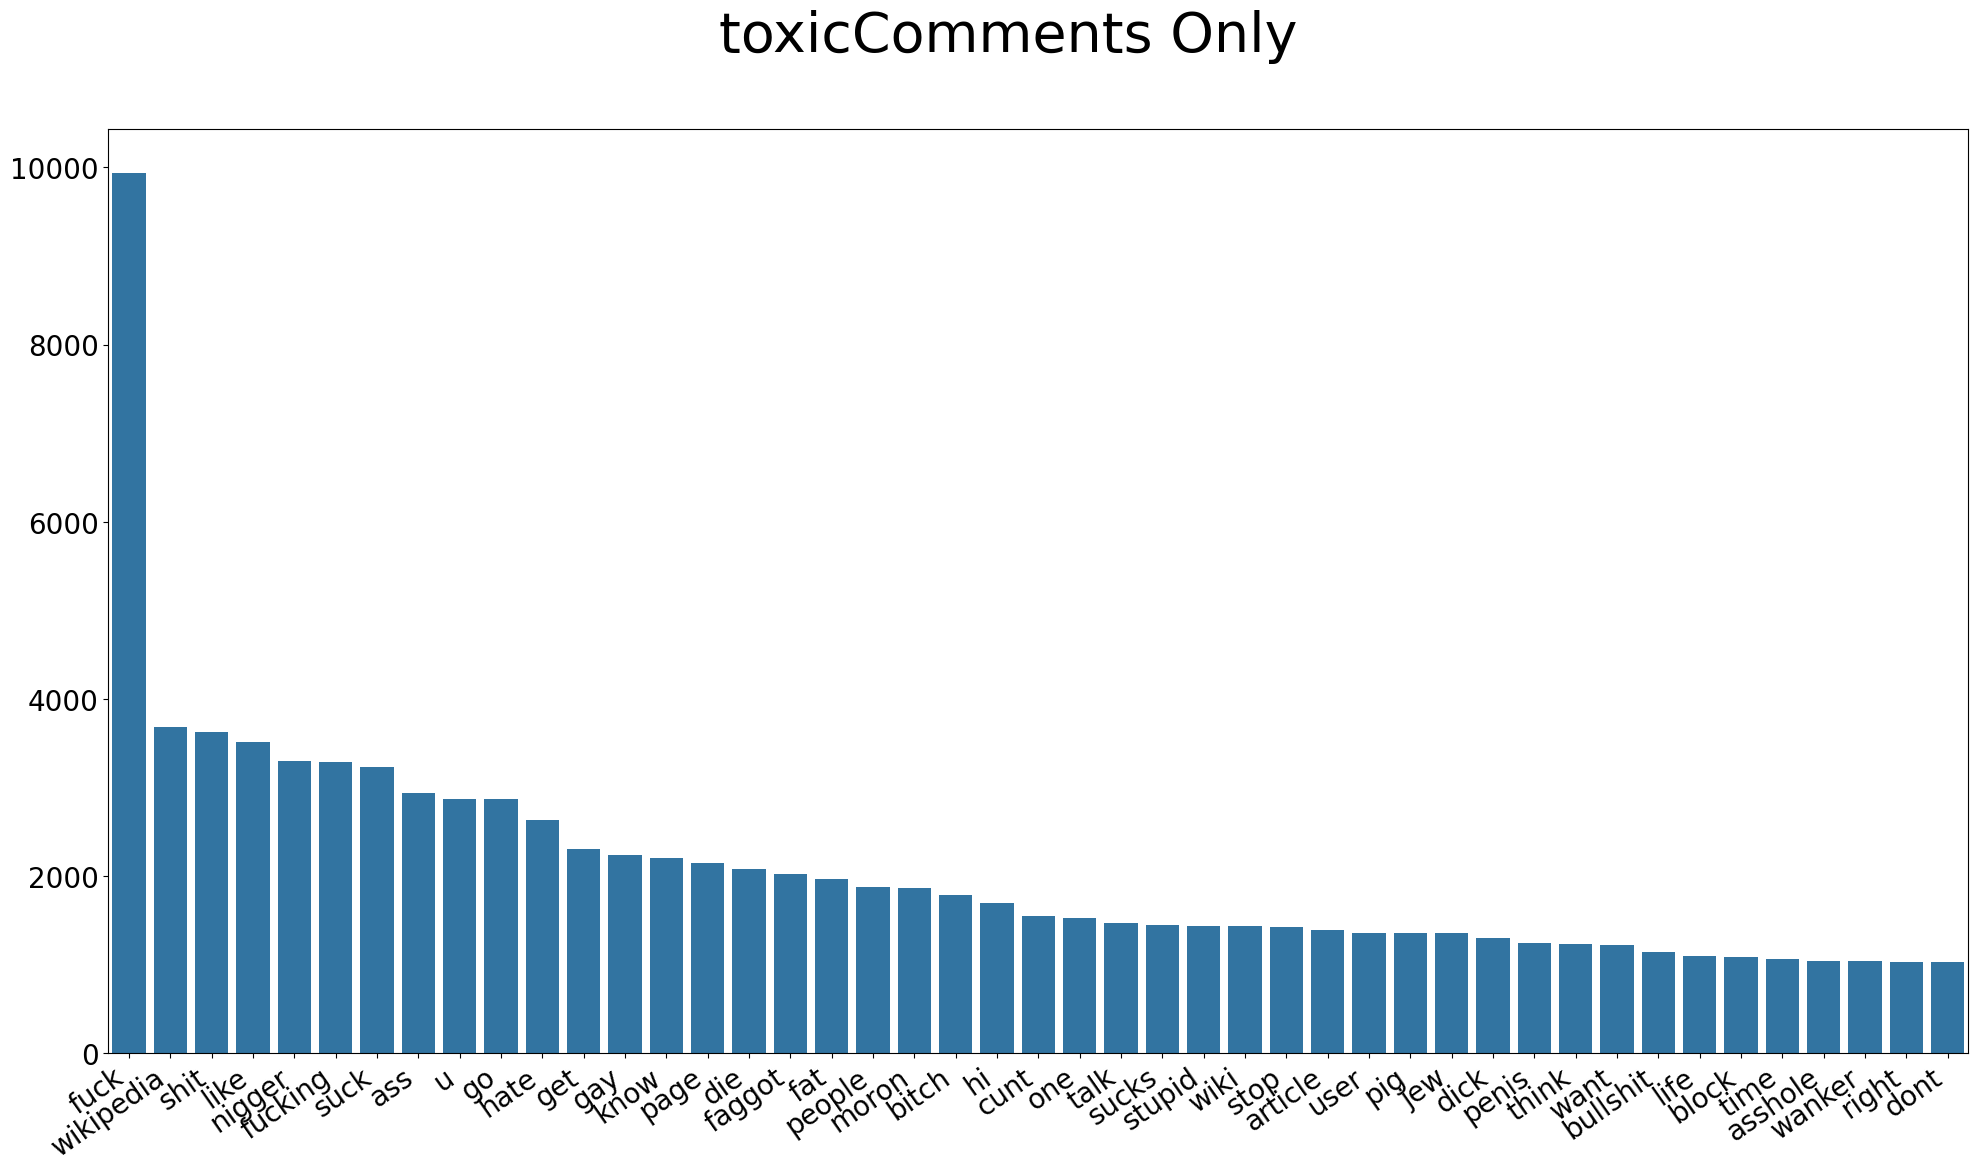

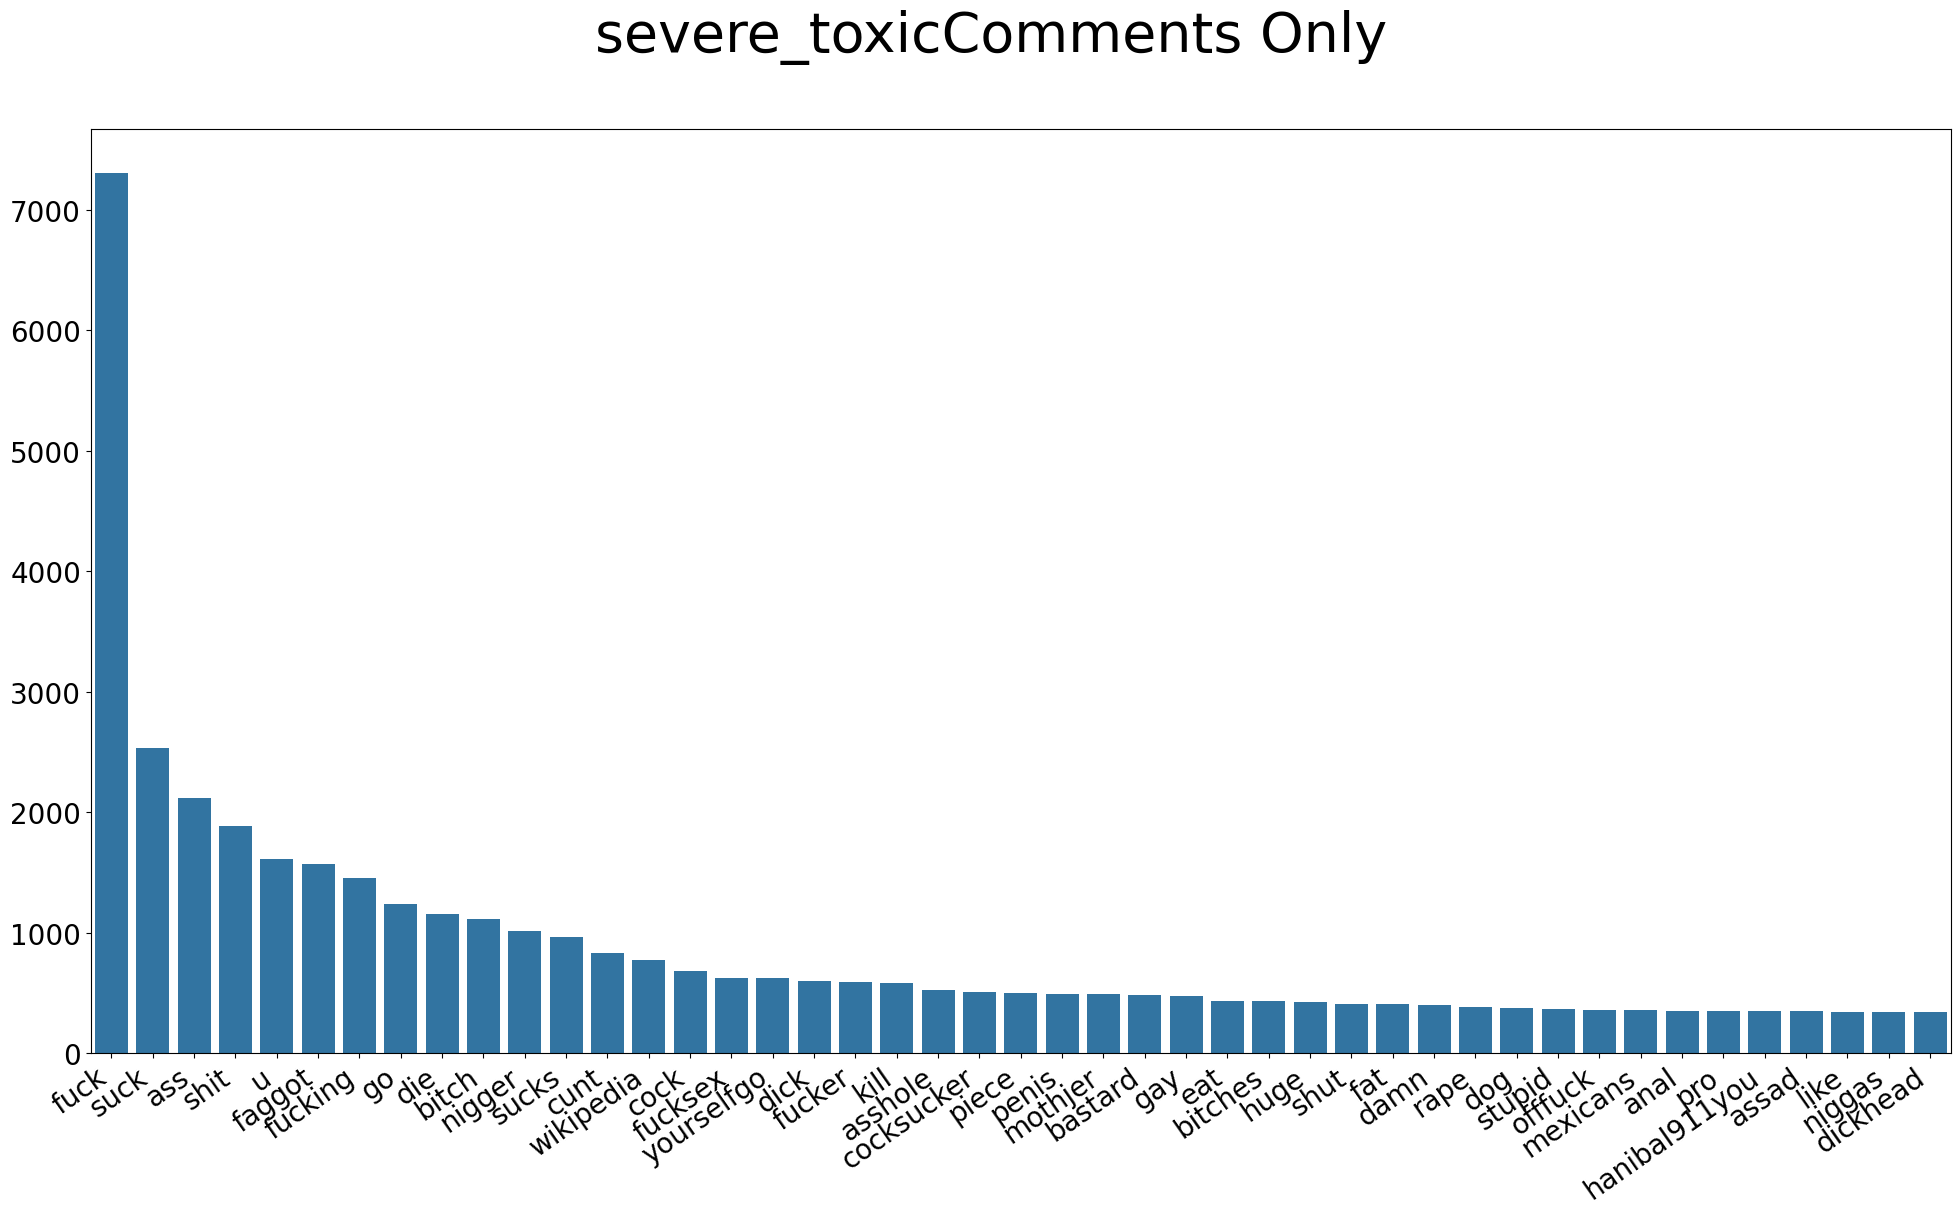

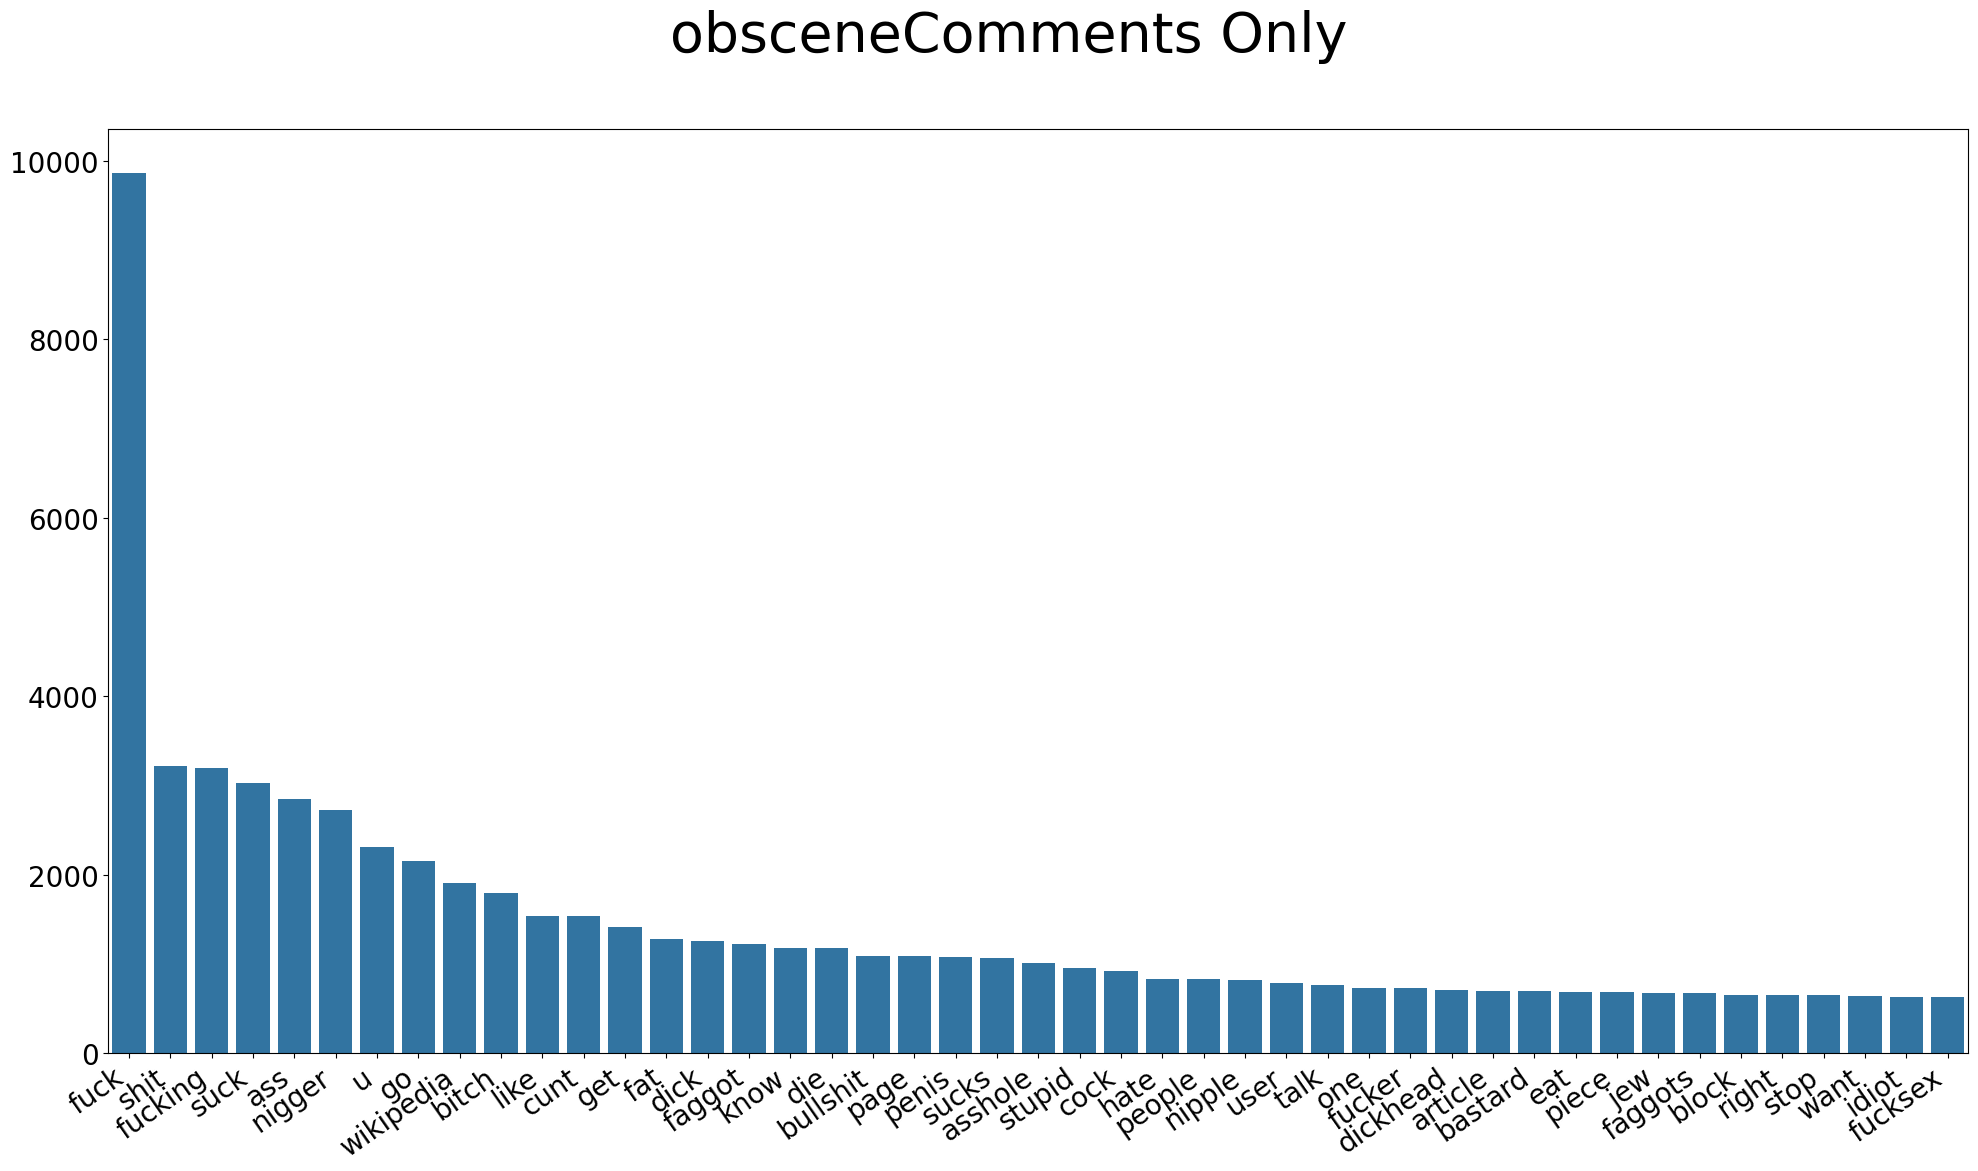

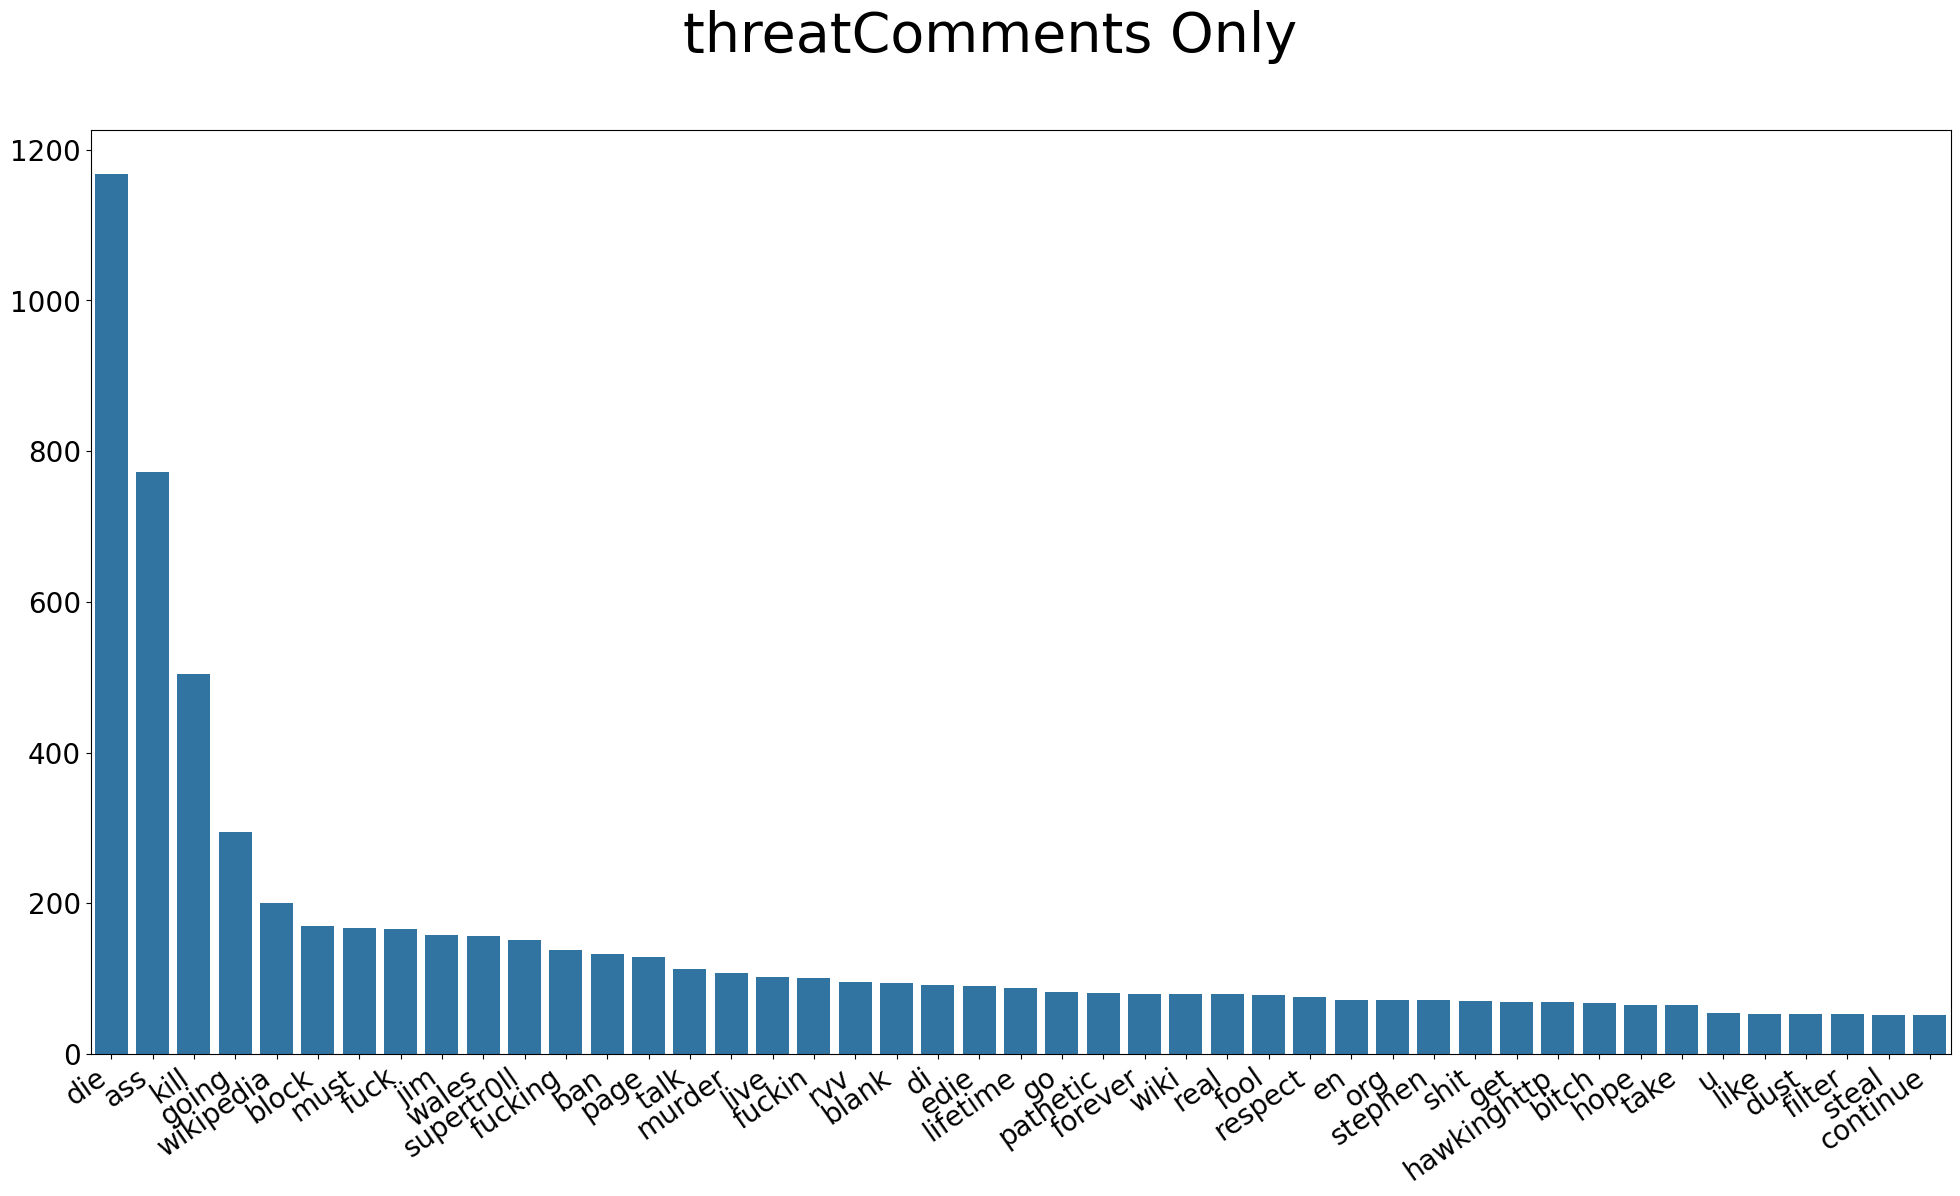

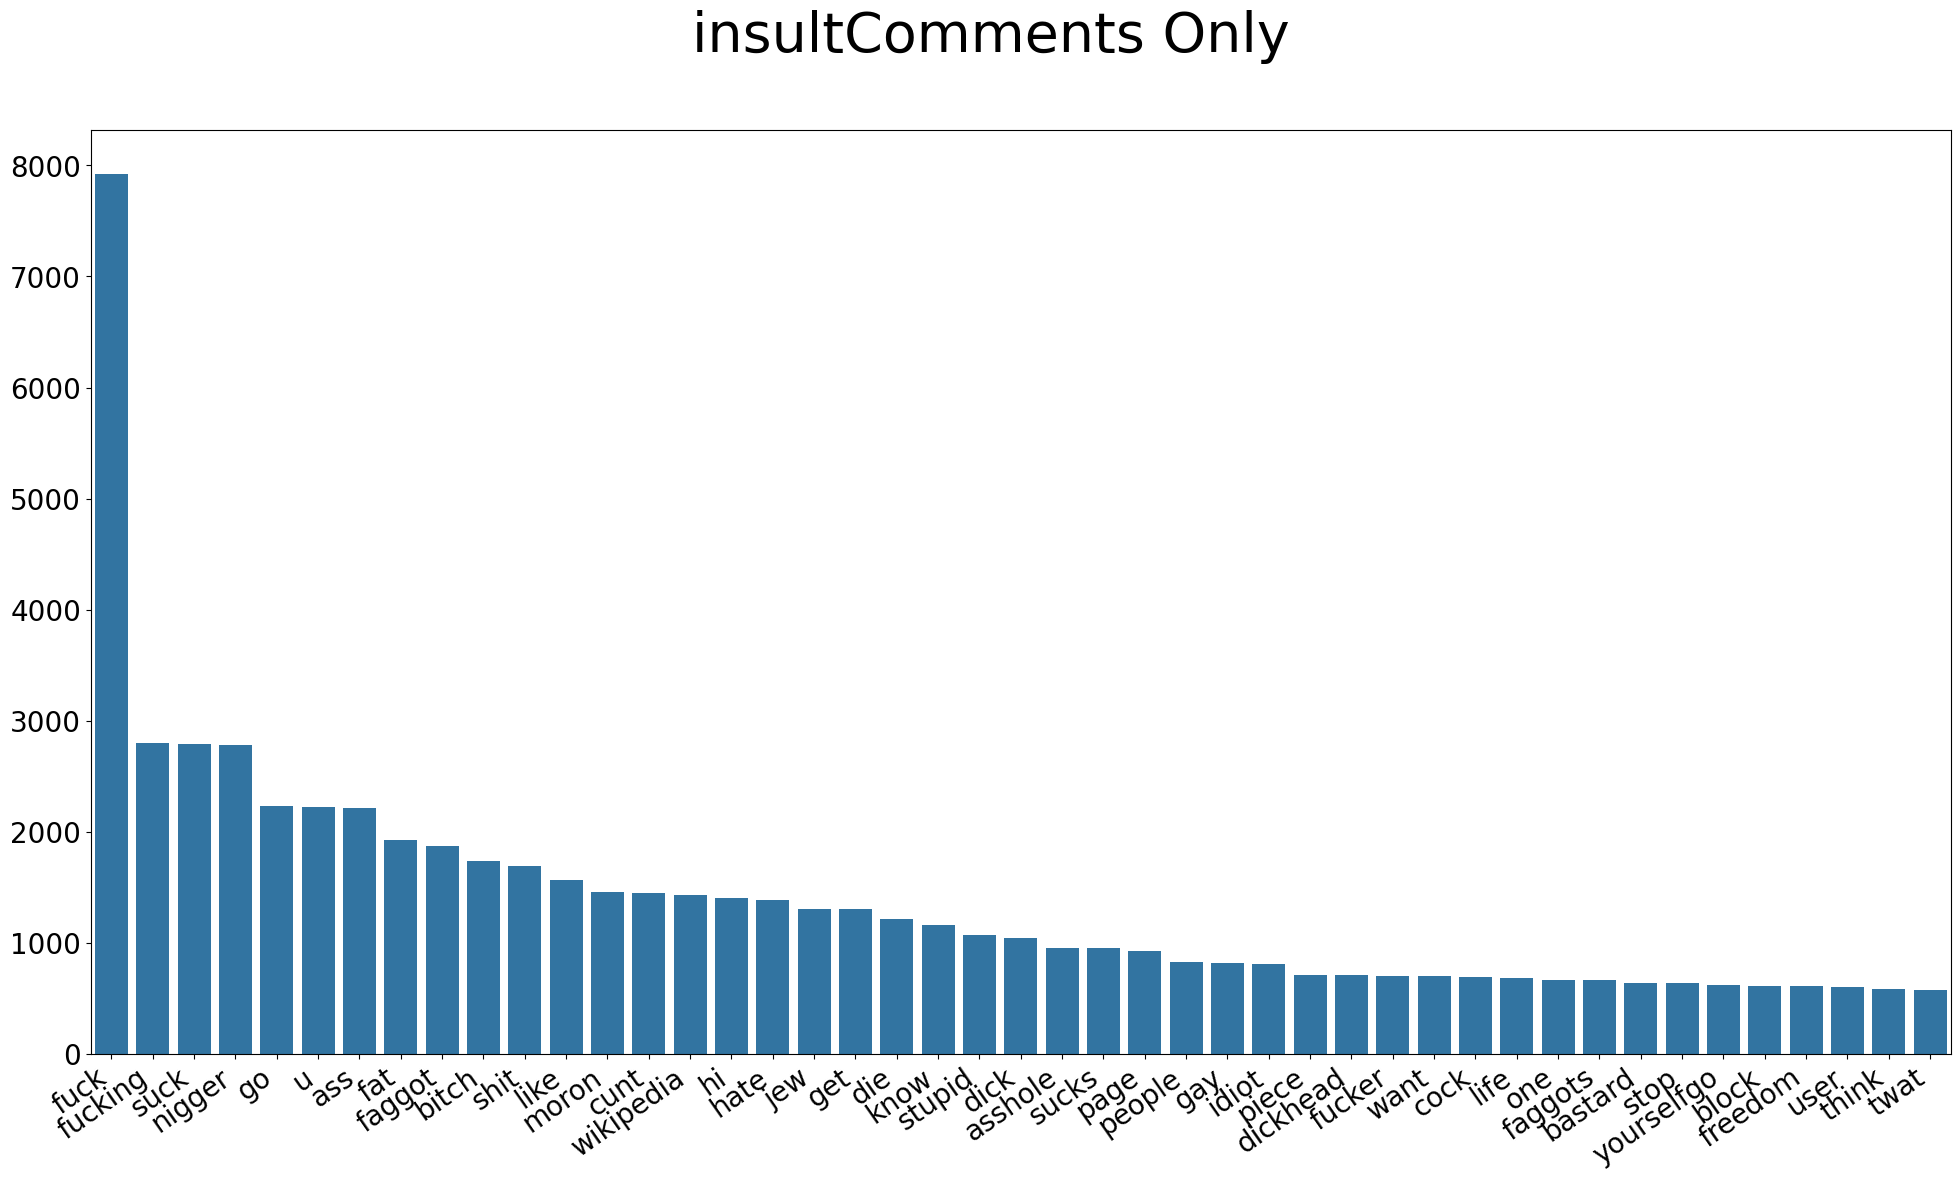

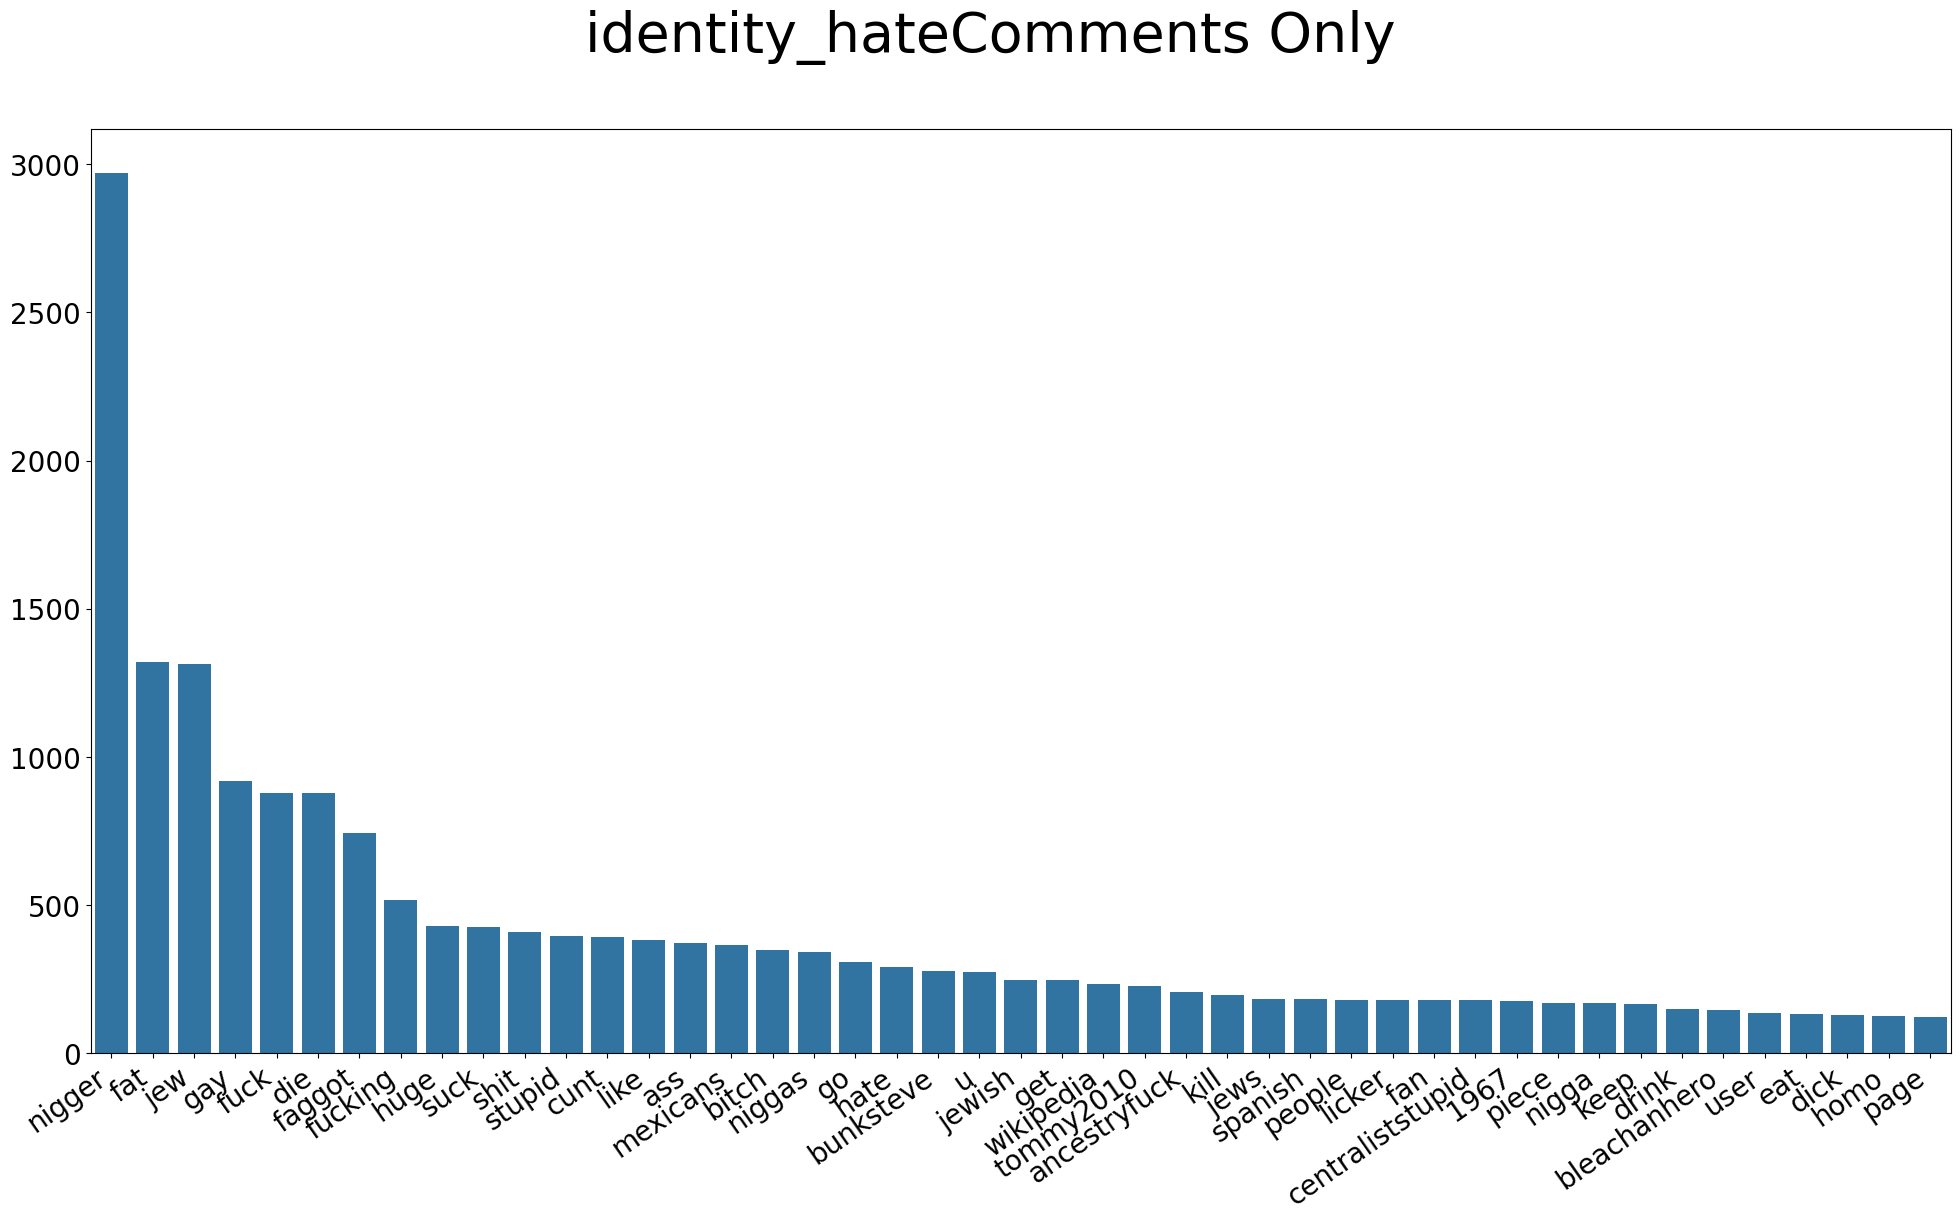

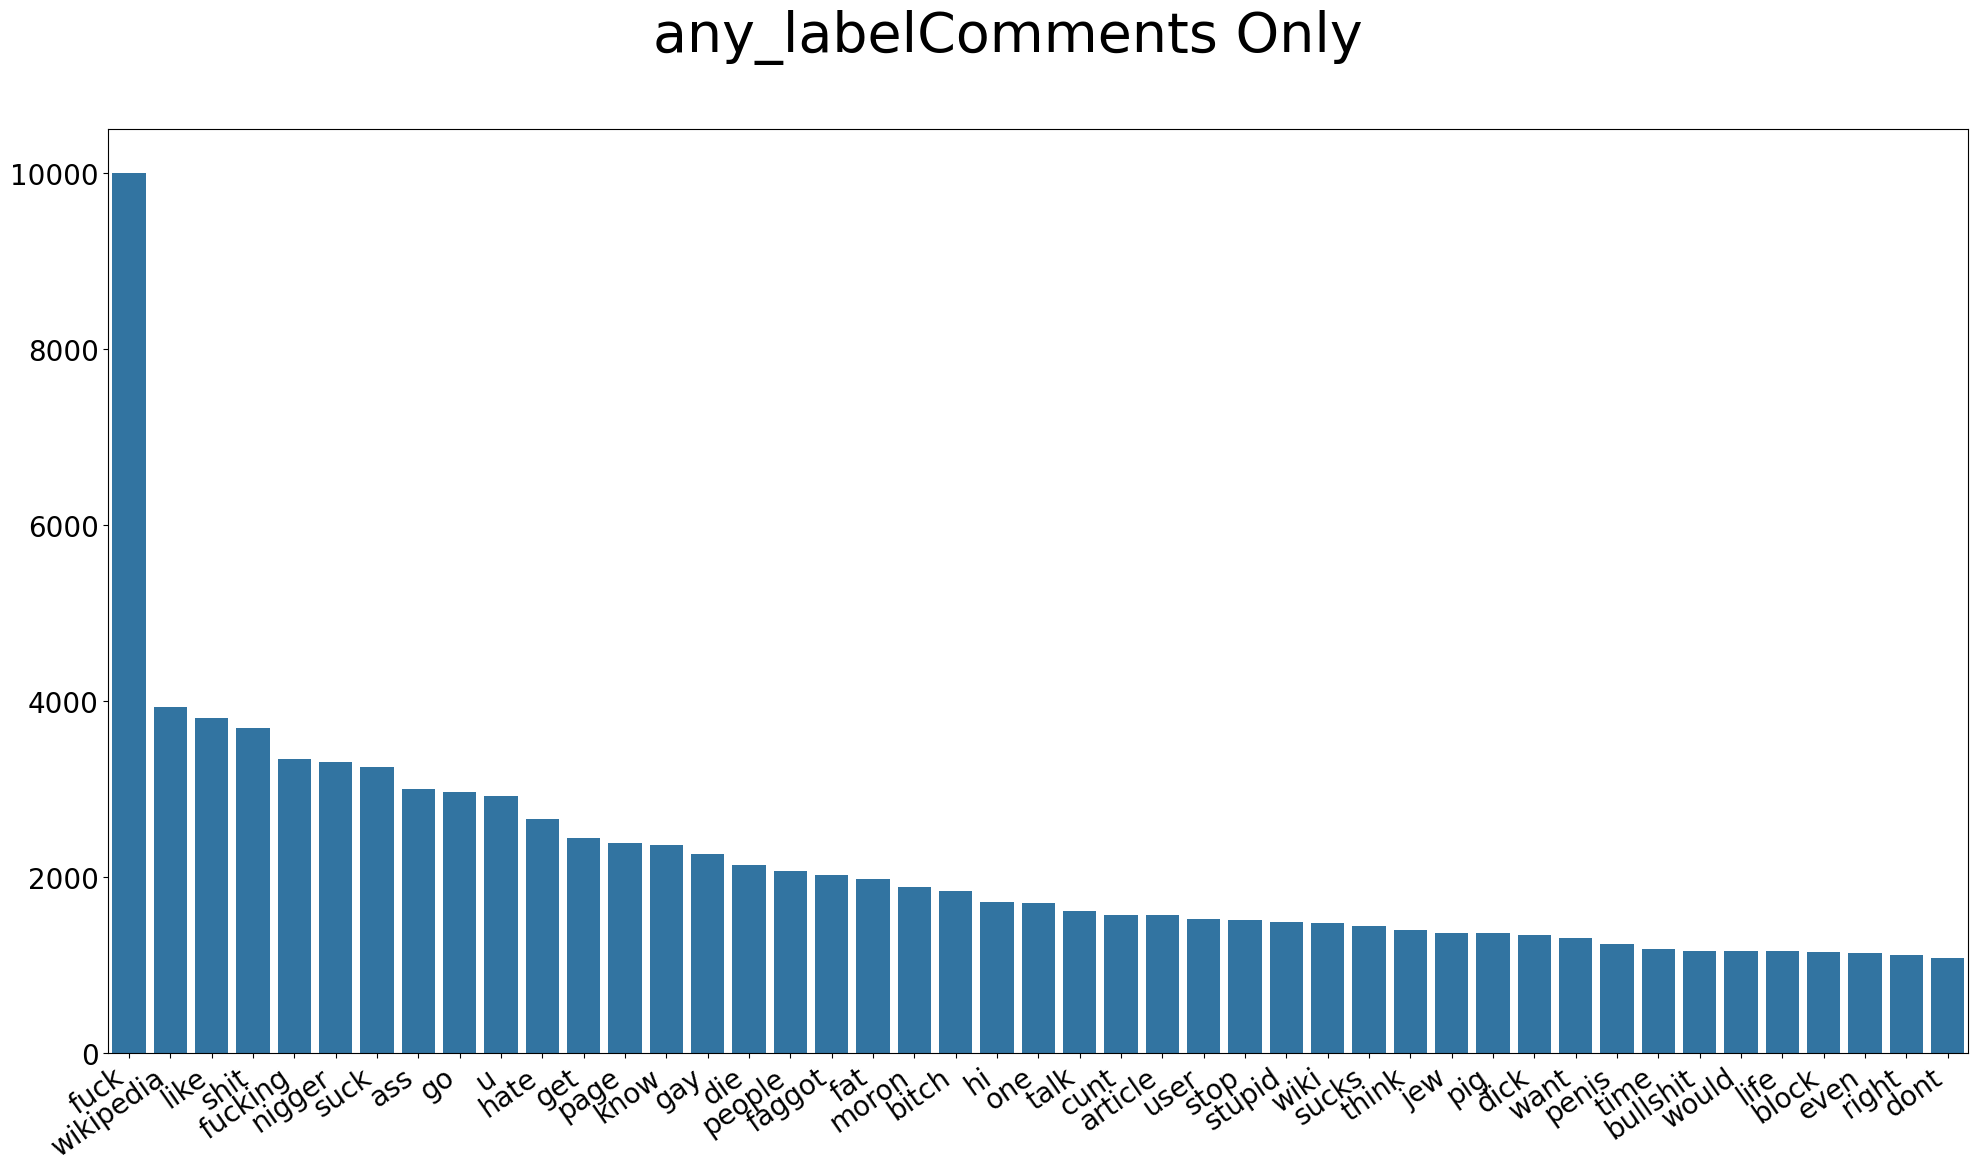

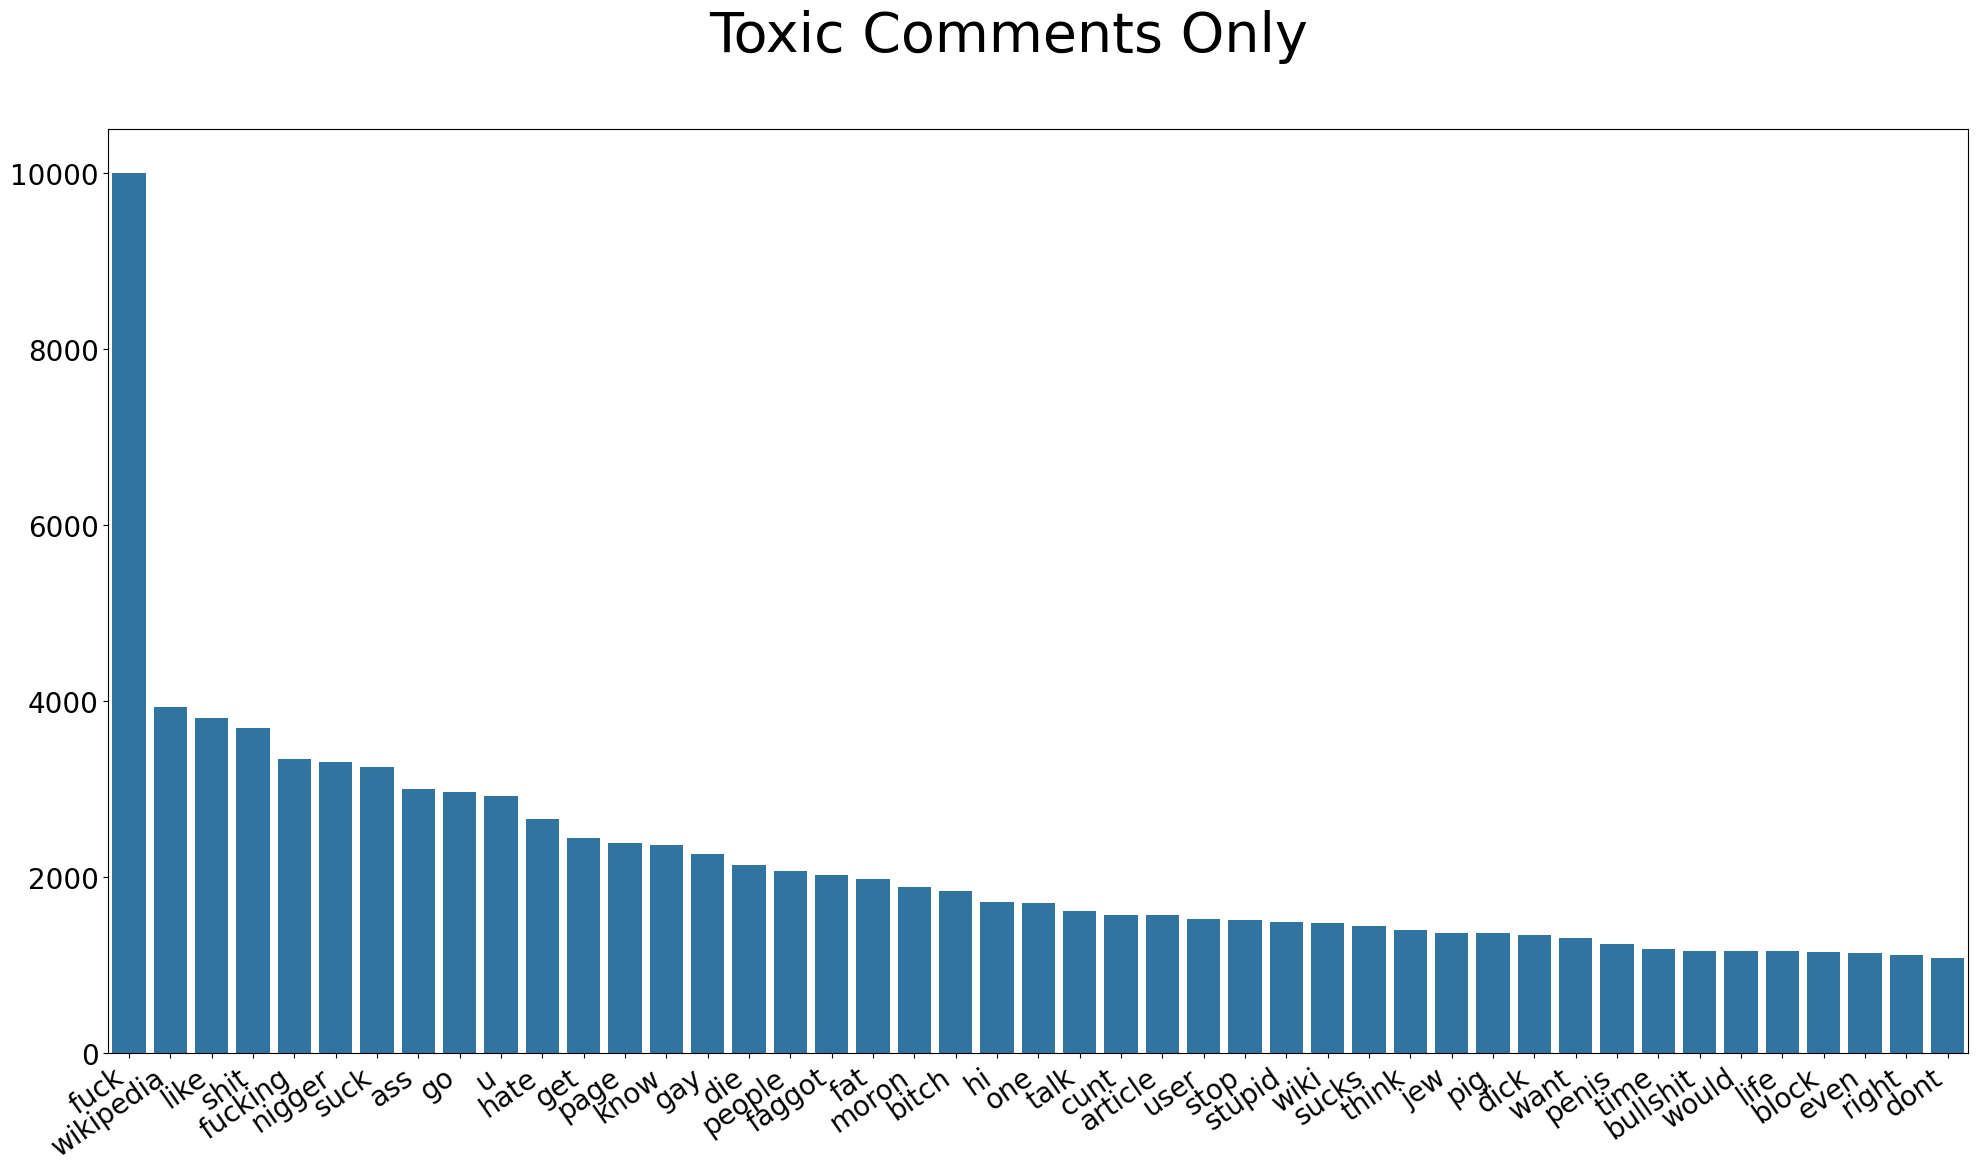

In [66]:
all_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
all_tokenizer.fit_on_texts(df.comment_text[(toxic_rows==0)])
word_plot(get_word_cnt(all_tokenizer), 45, 'Clean Comments Only')

for label in targets:
  toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
  toxic_tokenizer.fit_on_texts(df.comment_text[(df_targets [label]==1)])
  word_plot(get_word_cnt(toxic_tokenizer), 45, label + 'Comments Only')

toxic_tokenizer =Tokenizer(filters=string.punctuation+'\n', lower=True)
toxic_tokenizer.fit_on_texts(df.comment_text[toxic_rows])
word_plot(get_word_cnt(toxic_tokenizer), 45, 'Toxic Comments Only')

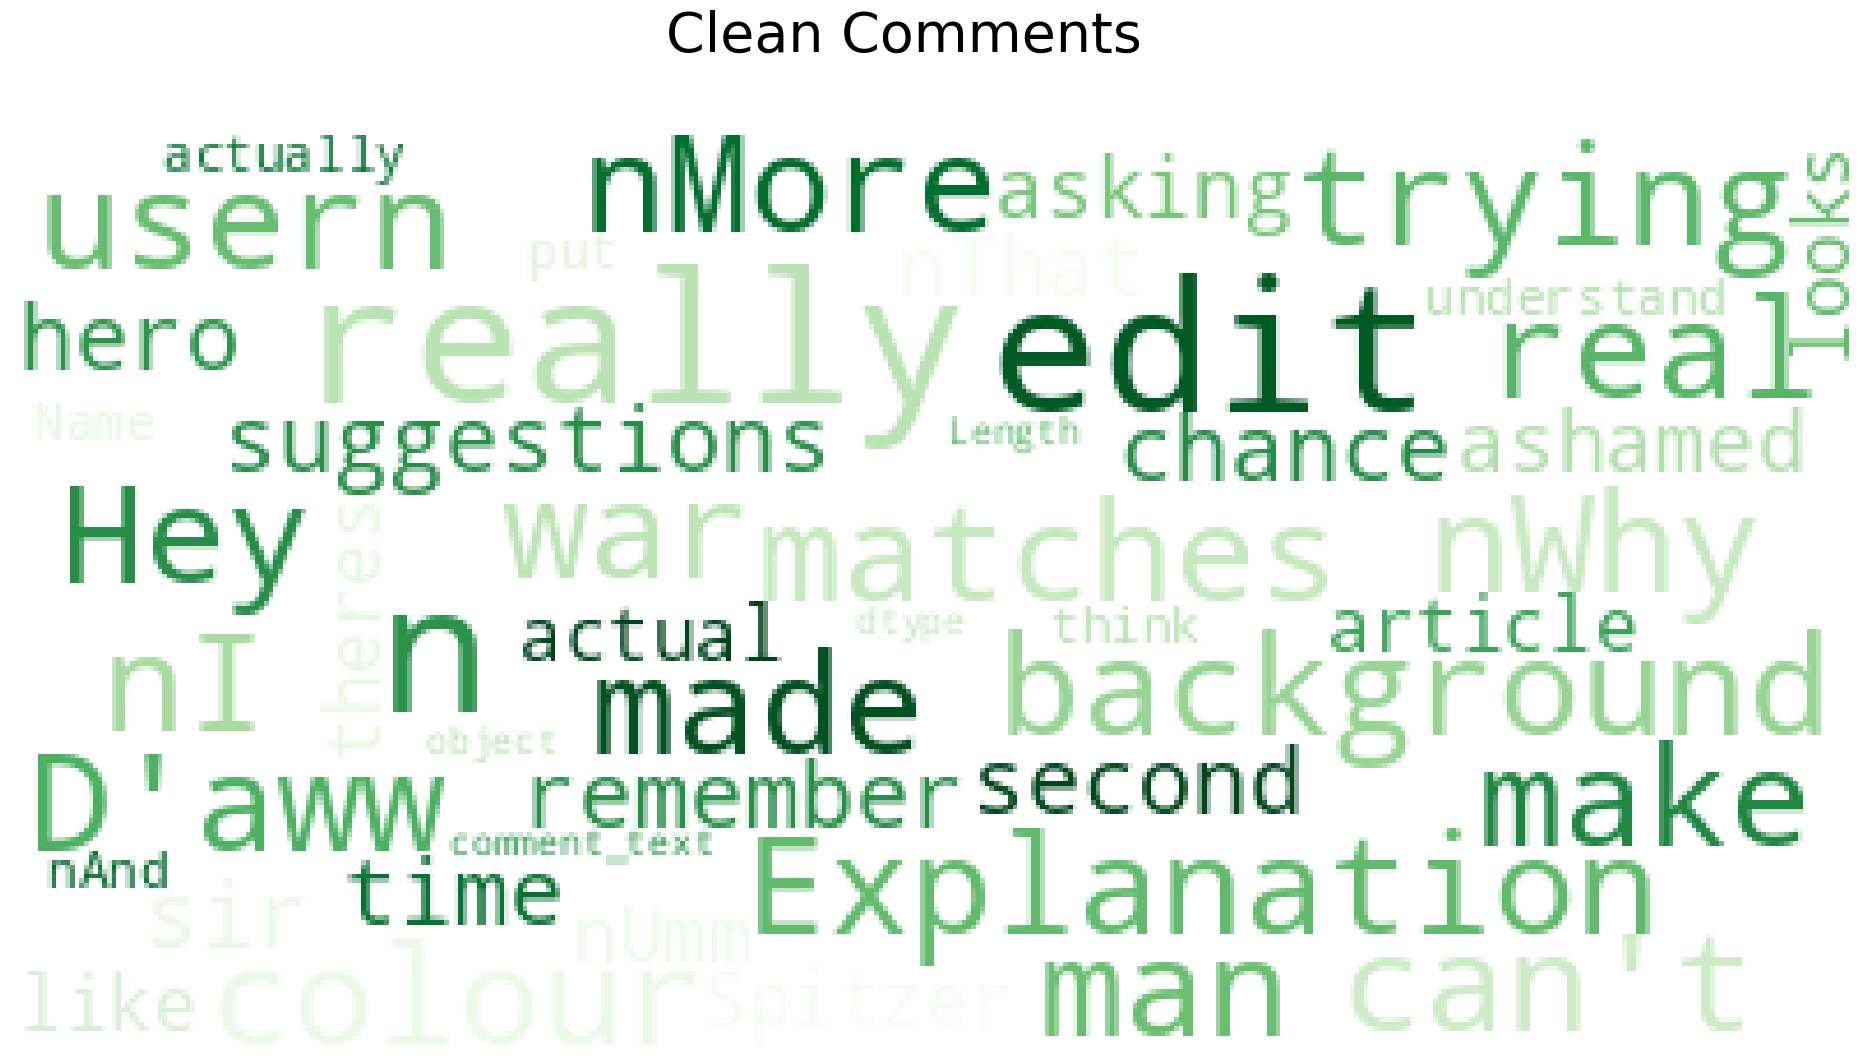

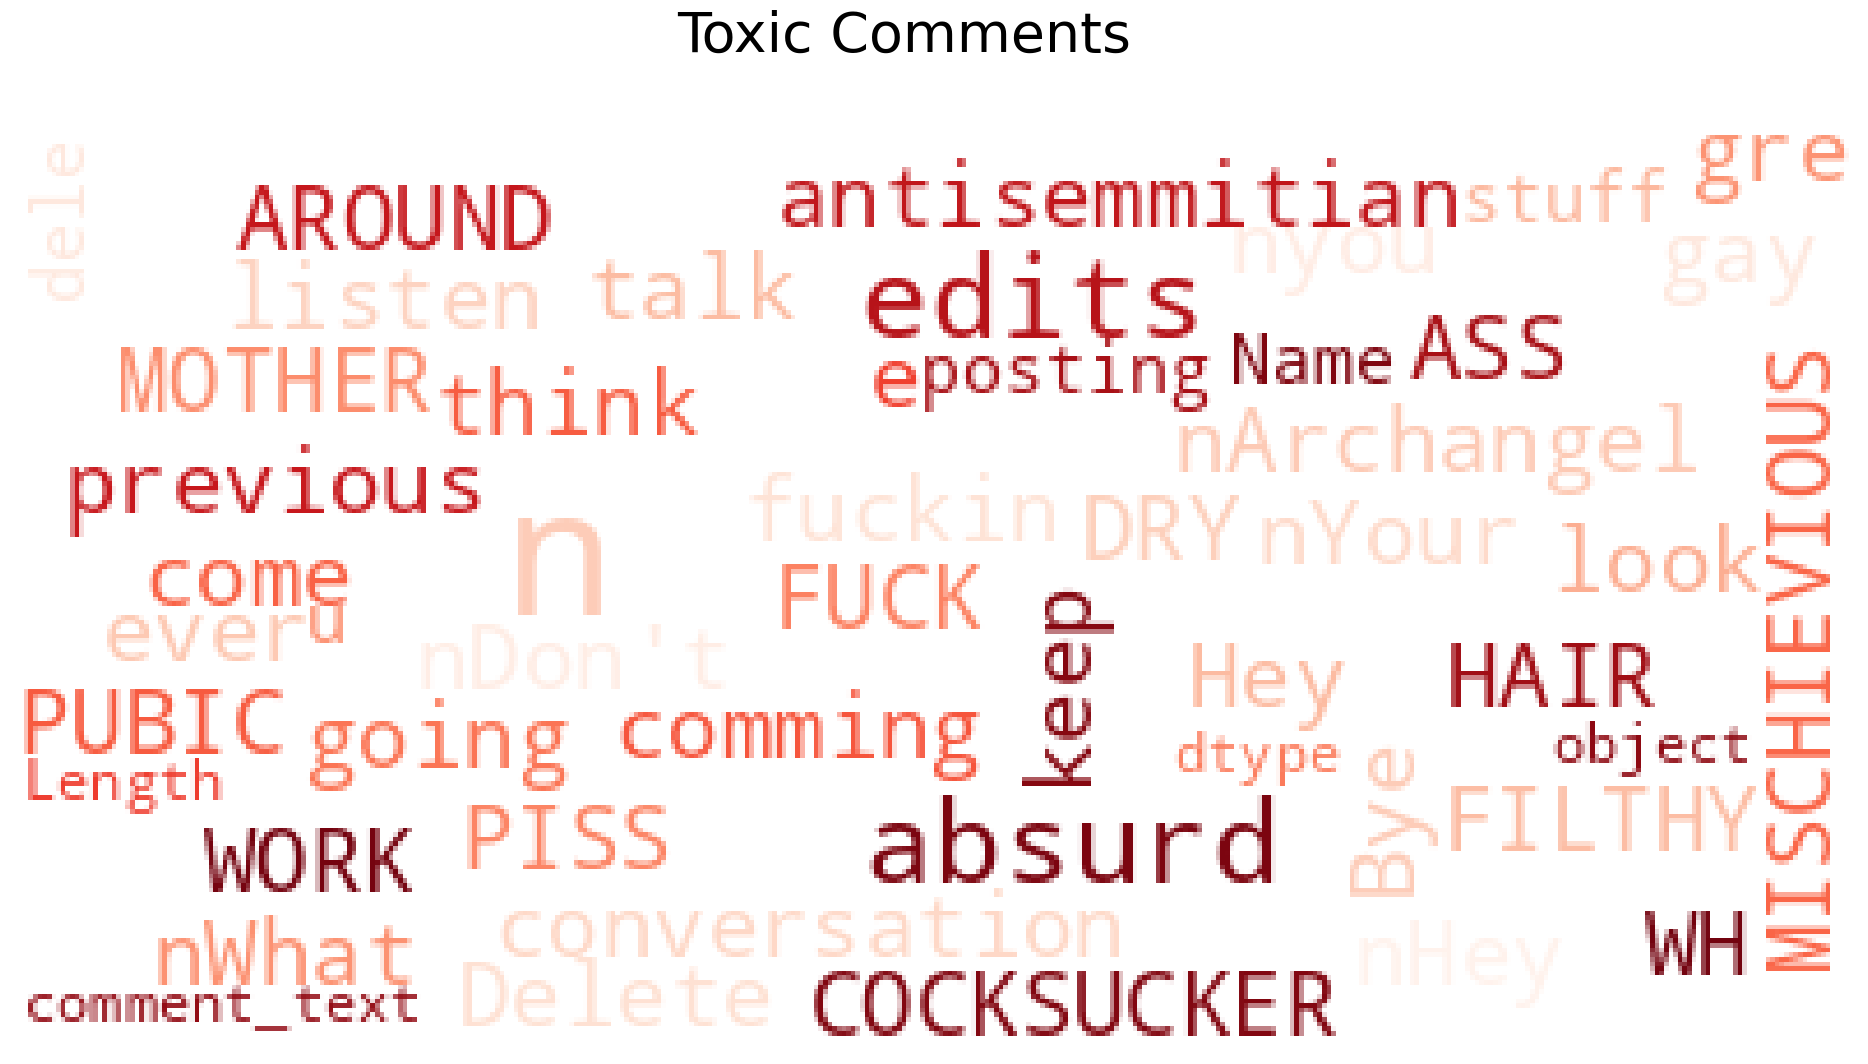

In [67]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white",
                      stopwords=set(stopwords.words('english')),
                      max_words=100,
                      max_font_size=40,
                      colormap= 'Greens'
                      ).generate(str(df.comment_text[(toxic_rows==0)]))

plt.figure('wordcloud', figsize=(24,12))
plt.suptitle('Clean Comments', fontsize=40)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

wordcloud = WordCloud (background_color='white',
                       stopwords=set(stopwords.words('english')),
                       max_words=100,
                       max_font_size=40,
                       colormap= 'Reds'
                       ).generate(str(df.comment_text[toxic_rows]))

plt.figure('toxic_wordcloud', figsize=(24,12))
plt.suptitle('Toxic Comments', fontsize=40)
plt.imshow(wordcloud)
plt.axis('off')

plt.show()